# Bone Fracture Detection with YOLOv8

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from ultralytics import YOLO
import os, cv2, random, shutil
import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def compute_class_multipliers(label_dir, class_names, target_count=None, max_multiplier=5, manual_overrides=None):
    """
    Computes class multipliers based on undersampling, with support for manual overrides.

    Args:
        label_dir (str): Directory with YOLO .txt label files.
        class_names (list): List of class names.
        target_count (int, optional): Target count to balance toward. Defaults to max class.
        max_multiplier (int): Maximum allowed multiplier.
        manual_overrides (dict): {class_id: override_multiplier}

    Returns:
        dict: {class_id: multiplier}
    """
    class_counts = {i: 0 for i in range(len(class_names))}
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    class_id = int(float(line.split()[0]))
                    class_counts[class_id] += 1

    if target_count is None:
        target_count = max(class_counts.values())

    print("\n--- Class Multipliers Suggestion ---")
    multipliers = {}
    for class_id, count in class_counts.items():
        if manual_overrides and class_id in manual_overrides:
            mult = manual_overrides[class_id]
        elif count == 0:
            mult = max_multiplier
        else:
            mult = min(max_multiplier, round(target_count / count))

        multipliers[class_id] = mult
        print(f"{class_names[class_id]} (class {class_id}): count = {count}, multiplier = {mult}")

    return multipliers

manual_boosts = {
    5: 2,  # shoulder fracture
    6: 3   # wrist positive
}

In [3]:
# Parse and Plot Class Distribution
def plot_class_distribution(label_dir, class_names):
    class_counts = {i: 0 for i in range(len(class_names))}
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    class_id = int(float(line.split()[0]))
                    class_counts[class_id] += 1

    # Plot
    plt.figure(figsize=(10, 5))
    labels = [class_names[i] for i in class_counts.keys()]
    counts = list(class_counts.values())
    plt.bar(labels, counts, color='skyblue')
    plt.xticks(rotation=45)
    plt.title("Class Distribution in Dataset")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [4]:
# Albumentations-Based Augment and Oversample
def parse_yolo_label(path):
    with open(path, 'r') as f:
        return [list(map(float, line.strip().split())) for line in f.readlines()]

def write_yolo_label(path, label_data):
    with open(path, 'w') as f:
        for label in label_data:
            f.write(' '.join(map(str, label)) + '\n')

def augment_and_oversample_with_albumentations(label_dir, image_dir, output_label_dir, output_image_dir, target_classes, class_names, class_multipliers):
    os.makedirs(output_label_dir, exist_ok=True)
    os.makedirs(output_image_dir, exist_ok=True)
    count = 0

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(p=0.3),
        A.Rotate(limit=15, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.3),
        A.MotionBlur(p=0.3)
    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels'],
        min_visibility=0.3,
        check_each_transform=True
    ))

    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        image_file = label_file.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_file)

        if not os.path.exists(image_path):
            continue

        labels = parse_yolo_label(label_path)
        img = cv2.imread(image_path)

        class_ids_in_file = {int(label[0]) for label in labels}
        for class_id in class_ids_in_file:
            if class_id in target_classes:
                multiplier = class_multipliers.get(class_id, 1)
                for i in range(multiplier):
                    bboxes = [label[1:] for label in labels]
                    class_labels = [int(label[0]) for label in labels]
                    try:
                        augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
                        if not augmented['bboxes']:
                            continue
                        aug_img = augmented['image']
                        aug_bboxes = augmented['bboxes']
                        aug_labels = augmented['class_labels']

                        new_name_txt = label_file.replace('.txt', f'_alb_{class_id}_{i}.txt')
                        new_name_img = image_file.replace('.jpg', f'_alb_{class_id}_{i}.jpg')

                        aug_label_data = [[cl] + list(bb) for cl, bb in zip(aug_labels, aug_bboxes)]
                        write_yolo_label(os.path.join(output_label_dir, new_name_txt), aug_label_data)
                        cv2.imwrite(os.path.join(output_image_dir, new_name_img), aug_img)
                        count += 1
                    except ValueError as e:
                        print(f"[Warning] Skipped {label_file} due to invalid bbox after augmentation: {e}")
                        continue
    print(f"[Albumentations] Augmented {count} new samples.")

In [5]:
class_names = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']

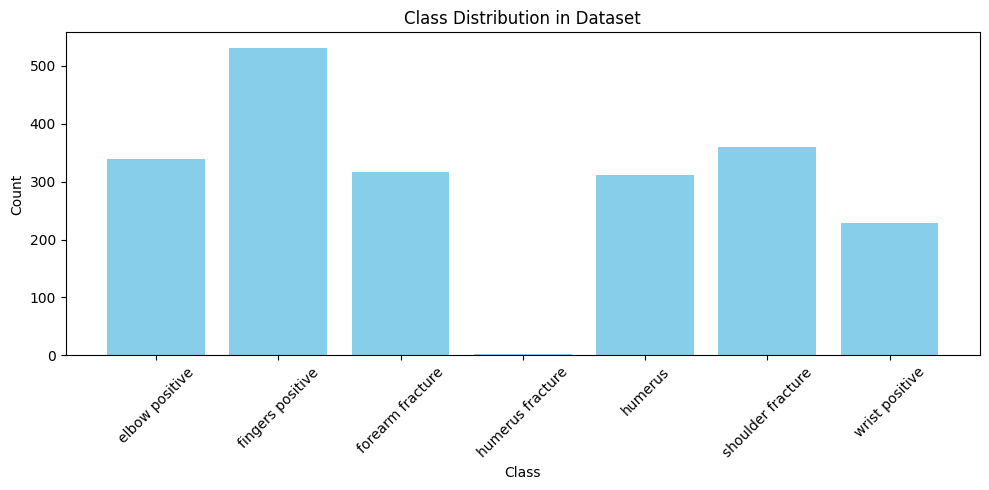

In [6]:
plot_class_distribution('./Dataset/datasets/BoneFractureYolo8/train/labels', class_names)

In [7]:
augment_and_oversample_with_albumentations(
    label_dir='./Dataset/datasets/BoneFractureYolo8/train/labels',
    image_dir='./Dataset/datasets/BoneFractureYolo8/train/images',
    output_label_dir='./Dataset/datasets/BoneFractureYolo8/train/labels',
    output_image_dir='./Dataset/datasets/BoneFractureYolo8/train/images',
    target_classes=[0, 1, 2, 3, 4, 5, 6],
    class_names=class_names,
    class_multipliers=compute_class_multipliers(
        './Dataset/datasets/BoneFractureYolo8/train/labels', 
        class_names,
        manual_overrides=manual_boosts
    )
)


--- Class Multipliers Suggestion ---
elbow positive (class 0): count = 339, multiplier = 2
fingers positive (class 1): count = 531, multiplier = 1
forearm fracture (class 2): count = 316, multiplier = 2
humerus fracture (class 3): count = 3, multiplier = 5
humerus (class 4): count = 311, multiplier = 2
shoulder fracture (class 5): count = 360, multiplier = 2
wrist positive (class 6): count = 228, multiplier = 3
[Warning] Skipped image1_1225_png.rf.dd2293e09f1af2a569b5cf4f3d805003.txt due to invalid bbox after augmentation: Expected y_max for bbox [    0.30759     0.37668     0.57404      1.1024     0.28422     0.80957     0.43182     0.80392     0.44081     0.73955           1] to be in the range [0.0, 1.0], got 1.102419376373291.
[Warning] Skipped image1_1334_png.rf.e27a0600d3093e3d3d811556f263614b.txt due to invalid bbox after augmentation: Expected x_max for bbox [    0.42326     0.48227      1.1447     0.90428     0.57489     0.42683     0.56066     0.43661     0.62104     0.70483

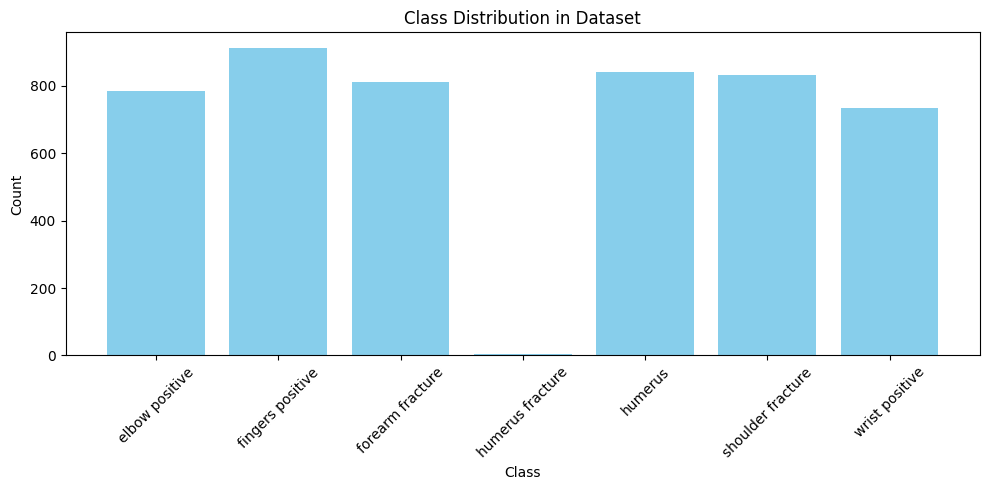

In [8]:
# Check updated class distribution
plot_class_distribution('./Dataset/datasets/BoneFractureYolo8/train/labels', class_names)

In [9]:
# Download YOLO model
train_model = YOLO('yolov8m.pt')

In [10]:
# Train YOLO model with early stopping and data augmentation
train_model.train(
    data='./Dataset/datasets/BoneFractureYolo8/data.yaml',
    epochs=100,
    patience=10,
    imgsz=512,
    device='mps',      # Use 'cuda' if on GPU
    degrees=10,        # rotation
    scale=0.5,         # zoom in/out
    shear=10,          # shearing
    perspective=0.001, # perspective distortion
    flipud=0.5,        # vertical flip
    fliplr=0.5,        # horizontal flip
    max_det=100
)

Ultralytics 8.3.104 🚀 Python-3.12.4 torch-2.5.1 MPS (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=./Dataset/datasets/BoneFractureYolo8/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=100, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /Users/rickson/Documents/BT5151 Bone Fracture Detection/Dataset/datasets/BoneFractureYolo8/train/labels... 6160 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 6160/6160 [00:01<00:00, 4110.92it/s]

train: New cache created: /Users/rickson/Documents/BT5151 Bone Fracture Detection/Dataset/datasets/BoneFractureYolo8/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/rickson/Documents/BT5151 Bone Fracture Detection/Dataset/datasets/BoneFractureYolo8/valid/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train10
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.74G      3.014      5.019      2.607         24        512: 100%|██████████| 385/385 [10:12<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:11<01:52, 11.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:16<01:12,  8.01s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:26<01:09,  8.67s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:32<00:53,  7.71s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:40<00:46,  7.81s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:46<00:35,  7.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:52<00:27,  6.81s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:58<00:19,  6.38s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:27<00:00,  7.97s/it]

                   all        348        204    0.00175      0.115    0.00173   0.000538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.9G      2.941       4.43       2.57         30        512: 100%|██████████| 385/385 [11:16<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:50,  5.07s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:10<00:45,  5.06s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:15<00:42,  5.32s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:21<00:38,  5.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:28<00:35,  5.96s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:34<00:29,  5.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:38<00:22,  5.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:45<00:17,  5.81s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:51<00:12,  6.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:59<00:06,  6.44s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:05<00:00,  5.98s/it]


                   all        348        204    0.00147     0.0674    0.00217   0.000566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.1G      2.896      4.419      2.535         21        512: 100%|██████████| 385/385 [10:50<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:06<01:05,  6.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:12<00:53,  5.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:18<00:51,  6.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:24<00:41,  5.90s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:28<00:32,  5.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:33<00:25,  5.16s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:38<00:19,  4.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:42<00:14,  4.90s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:47<00:09,  4.84s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:52<00:04,  4.90s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:56<00:00,  5.17s/it]


                   all        348        204    0.00068     0.0632    0.00229   0.000648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.5G       2.88      4.337      2.508         24        512: 100%|██████████| 385/385 [10:50<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:06<01:03,  6.39s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:11<00:49,  5.49s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:18<00:49,  6.23s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:23<00:39,  5.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:28<00:33,  5.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:33<00:27,  5.43s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:39<00:21,  5.45s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:44<00:15,  5.31s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:49<00:10,  5.43s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:54<00:05,  5.34s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:59<00:00,  5.43s/it]


                   all        348        204       0.88    0.00463    0.00903    0.00299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G      2.816      4.205      2.418         16        512: 100%|██████████| 385/385 [11:10<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:57,  5.80s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:10<00:48,  5.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:18<00:51,  6.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:23<00:40,  5.82s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:28<00:34,  5.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:34<00:28,  5.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:40<00:22,  5.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:47<00:18,  6.14s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:53<00:12,  6.17s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:58<00:05,  5.90s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:03<00:00,  5.81s/it]


                   all        348        204      0.942     0.0139     0.0222    0.00794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      15.1G      2.757      4.074      2.399         17        512: 100%|██████████| 385/385 [11:05<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:09<01:33,  9.30s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:14<01:03,  7.03s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:22<00:59,  7.44s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:28<00:47,  6.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:33<00:36,  6.10s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:37<00:27,  5.57s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:42<00:21,  5.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:47<00:15,  5.17s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:52<00:09,  5.00s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:57<00:04,  4.98s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:02<00:00,  5.70s/it]


                   all        348        204      0.796     0.0208     0.0192    0.00742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      15.6G      2.714       3.94      2.375         19        512: 100%|██████████| 385/385 [12:01<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:52,  5.23s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:10<00:49,  5.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:17<00:47,  5.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:23<00:41,  5.94s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:28<00:33,  5.57s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:32<00:26,  5.24s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:37<00:20,  5.16s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:42<00:15,  5.11s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:48<00:10,  5.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:53<00:05,  5.10s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:57<00:00,  5.24s/it]


                   all        348        204      0.421     0.0294     0.0194    0.00681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      16.1G       2.66      3.849      2.358         15        512: 100%|██████████| 385/385 [11:37<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:56,  5.63s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:12<00:54,  6.08s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:19<00:52,  6.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:25<00:46,  6.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:31<00:36,  6.15s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:35<00:28,  5.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:43<00:24,  6.17s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:48<00:17,  5.79s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:53<00:11,  5.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:58<00:05,  5.40s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:04<00:00,  5.89s/it]


                   all        348        204      0.769     0.0301     0.0293     0.0134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      16.6G      2.653      3.784      2.346         16        512: 100%|██████████| 385/385 [11:55<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:52,  5.21s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:11<00:52,  5.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:18<00:50,  6.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:24<00:43,  6.18s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:30<00:37,  6.24s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:35<00:28,  5.66s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:41<00:23,  5.97s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:46<00:16,  5.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:51<00:10,  5.45s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:56<00:05,  5.17s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:00<00:00,  5.53s/it]


                   all        348        204      0.744     0.0371     0.0327     0.0133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      17.1G      2.636      3.698      2.326         20        512: 100%|██████████| 385/385 [11:17<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:53,  5.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:12<00:55,  6.20s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:18<00:51,  6.48s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:24<00:43,  6.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:29<00:34,  5.75s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:34<00:27,  5.42s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:45<00:16,  5.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:49<00:10,  5.20s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:56<00:05,  5.57s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:01<00:00,  5.61s/it]


                   all        348        204      0.595     0.0583     0.0383     0.0152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      17.6G      2.621      3.663      2.323         20        512: 100%|██████████| 385/385 [11:30<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:07<01:14,  7.48s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:14<01:03,  7.06s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:21<00:57,  7.13s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:29<00:51,  7.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:35<00:41,  6.95s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:41<00:33,  6.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:47<00:26,  6.55s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:53<00:19,  6.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:59<00:12,  6.01s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [01:05<00:06,  6.20s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:09<00:00,  6.36s/it]


                   all        348        204        0.7     0.0571      0.048     0.0206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      18.1G      2.588      3.626      2.306         26        512: 100%|██████████| 385/385 [11:20<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:07<01:19,  7.96s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:15<01:07,  7.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:26<01:14,  9.28s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:56<00:30,  7.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:22<00:00,  7.48s/it]


                   all        348        204      0.429     0.0797     0.0747     0.0294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      18.6G       2.61      3.536      2.292         24        512: 100%|██████████| 385/385 [11:12<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:06<01:00,  6.01s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:42<00:31,  6.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:54<00:18,  6.06s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [01:04<00:05,  5.32s/it]

WARNING ⚠️ NMS time limit 3.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:09<00:00,  6.28s/it]


                   all        348        204      0.785     0.0634     0.0736     0.0244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100        19G      2.557      3.489      2.274         23        512: 100%|██████████| 385/385 [10:26<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:12<00:56,  6.31s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:21<01:00,  7.51s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:40<00:20,  5.06s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:46<00:16,  5.45s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:05<00:00,  5.93s/it]


                   all        348        204        0.8     0.0749      0.102     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      19.4G      2.571      3.453      2.277         21        512: 100%|██████████| 385/385 [10:41<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:10<00:49,  5.47s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:18<00:51,  6.48s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:31<00:37,  6.20s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:38<00:19,  4.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:44<00:15,  5.07s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:58<00:00,  5.29s/it]


                   all        348        204      0.479      0.115      0.102     0.0423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      19.8G      2.525      3.387      2.238         18        512: 100%|██████████| 385/385 [10:57<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:09<00:45,  5.07s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:40<00:14,  4.90s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:54<00:00,  4.92s/it]


                   all        348        204      0.841      0.104      0.124     0.0496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      20.3G      2.528      3.345      2.237         28        512: 100%|██████████| 385/385 [11:23<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:51,  5.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:11<00:53,  5.98s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:19<00:52,  6.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:43<00:14,  4.67s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:53<00:00,  4.90s/it]


                   all        348        204      0.626      0.166      0.153     0.0515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      20.8G      2.526      3.289      2.231         26        512: 100%|██████████| 385/385 [12:15<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:10<00:48,  5.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:00<00:00,  5.51s/it]


                   all        348        204      0.323       0.11      0.103     0.0363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      21.3G      2.501      3.294      2.227         20        512: 100%|██████████| 385/385 [11:28<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:59,  5.98s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:12<00:57,  6.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:20<00:55,  6.94s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:05<00:00,  6.00s/it]


                   all        348        204      0.166      0.121      0.103     0.0413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      21.7G      2.486      3.196      2.192         25        512: 100%|██████████| 385/385 [11:16<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:52,  5.25s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:11<00:52,  5.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:38<00:11,  3.87s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:48<00:00,  4.38s/it]


                   all        348        204      0.186      0.159      0.132     0.0463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100        22G      2.463      3.201      2.199         21        512: 100%|██████████| 385/385 [10:41<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:06<01:04,  6.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:13<01:01,  6.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:21<00:57,  7.15s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:42<00:12,  4.09s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:55<00:00,  5.08s/it]


                   all        348        204      0.315      0.135      0.129      0.041

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      22.4G      2.457      3.162      2.198         27        512: 100%|██████████| 385/385 [10:56<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:05<00:53,  5.38s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:11<00:52,  5.87s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:26<00:28,  4.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:56<00:00,  5.10s/it]


                   all        348        204       0.25      0.187      0.156     0.0635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      22.8G      2.454      3.166       2.19         16        512: 100%|██████████| 385/385 [10:59<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:08<00:38,  4.29s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:46<00:00,  4.19s/it]


                   all        348        204      0.275      0.165      0.157     0.0532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      23.2G      2.435      3.096      2.157         17        512: 100%|██████████| 385/385 [10:54<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:10<00:46,  5.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:47<00:00,  4.28s/it]


                   all        348        204      0.253      0.154      0.146     0.0519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      23.5G      2.435      3.047      2.161         23        512: 100%|██████████| 385/385 [10:39<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:41<00:00,  3.79s/it]


                   all        348        204      0.195      0.189      0.163     0.0635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      23.9G      2.426      3.058      2.142         17        512: 100%|██████████| 385/385 [10:21<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:46<00:00,  4.24s/it]


                   all        348        204      0.315      0.205      0.209      0.082

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      24.2G      2.426      3.012      2.142         19        512: 100%|██████████| 385/385 [10:28<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:41<00:00,  3.81s/it]


                   all        348        204      0.284       0.24      0.221      0.083

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      24.5G      2.415      2.994      2.126         22        512: 100%|██████████| 385/385 [10:05<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:11<00:50,  5.56s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:42<00:00,  3.86s/it]


                   all        348        204      0.427      0.232      0.219     0.0774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      24.9G      2.402       2.95      2.128         19        512: 100%|██████████| 385/385 [10:26<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:59<00:00,  5.42s/it]


                   all        348        204      0.247      0.215      0.193      0.073

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      25.4G      2.387       2.94      2.113         24        512: 100%|██████████| 385/385 [11:23<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


                   all        348        204      0.325      0.238      0.211     0.0812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      25.7G      2.404      2.948      2.137         19        512: 100%|██████████| 385/385 [10:33<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


                   all        348        204      0.299      0.212       0.19      0.071

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      26.1G      2.386      2.951       2.13         30        512: 100%|██████████| 385/385 [09:47<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:45<00:00,  4.18s/it]


                   all        348        204      0.164      0.208      0.186      0.064

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      26.4G      2.368      2.886      2.107         26        512: 100%|██████████| 385/385 [09:56<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:53<00:00,  4.88s/it]


                   all        348        204      0.204      0.245      0.203     0.0764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      26.8G      2.361      2.842      2.106         18        512: 100%|██████████| 385/385 [10:06<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:57<00:00,  5.22s/it]


                   all        348        204      0.435        0.2      0.219     0.0817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      27.1G      2.346      2.817      2.078         14        512: 100%|██████████| 385/385 [09:27<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:49<00:00,  4.54s/it]


                   all        348        204      0.284       0.22      0.219     0.0777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      27.4G      2.341      2.829      2.108         23        512: 100%|██████████| 385/385 [10:16<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:48<00:00,  4.45s/it]


                   all        348        204      0.328       0.25      0.252     0.0884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      27.9G      2.344      2.784      2.083         22        512: 100%|██████████| 385/385 [10:25<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:56<00:00,  5.16s/it]


                   all        348        204      0.296      0.244      0.236      0.085

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      28.2G      2.331      2.751      2.077         20        512: 100%|██████████| 385/385 [10:38<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:06<00:00,  6.01s/it]


                   all        348        204      0.265      0.264      0.231     0.0876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      28.5G      2.309       2.72      2.059         28        512: 100%|██████████| 385/385 [09:45<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:00<00:00,  5.49s/it]


                   all        348        204      0.287       0.26      0.238     0.0874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      28.9G       2.32      2.711      2.065         34        512: 100%|██████████| 385/385 [10:48<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:59<00:00,  5.44s/it]


                   all        348        204      0.269      0.276      0.226     0.0779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      29.1G      2.301      2.675      2.064         13        512: 100%|██████████| 385/385 [09:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:53<00:00,  4.88s/it]


                   all        348        204      0.352      0.318      0.275      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      29.4G      2.271      2.661      2.043         25        512: 100%|██████████| 385/385 [10:09<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


                   all        348        204      0.318      0.319      0.259     0.0917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      29.7G      2.274      2.613      2.027         29        512: 100%|██████████| 385/385 [09:34<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:49<00:00,  4.51s/it]


                   all        348        204      0.298      0.317      0.247     0.0863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100        30G      2.274      2.611      2.034         24        512: 100%|██████████| 385/385 [09:59<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:47<00:00,  4.36s/it]


                   all        348        204      0.224      0.275      0.257     0.0908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      30.3G      2.256       2.58      2.017         18        512: 100%|██████████| 385/385 [10:13<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:53<00:00,  4.86s/it]


                   all        348        204      0.345      0.278      0.283     0.0971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      30.7G      2.224      2.544      2.004         14        512: 100%|██████████| 385/385 [09:58<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:57<00:00,  5.19s/it]


                   all        348        204      0.315      0.289      0.275     0.0943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      31.1G      2.252      2.531      2.006         19        512: 100%|██████████| 385/385 [10:24<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:08<00:00,  6.26s/it]


                   all        348        204      0.283       0.26      0.221      0.078

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      31.5G      2.261      2.521      2.021         23        512: 100%|██████████| 385/385 [09:37<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:50<00:00,  4.58s/it]


                   all        348        204      0.301      0.271      0.251      0.084

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      31.7G      2.216      2.491      1.986         18        512: 100%|██████████| 385/385 [08:59<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:50<00:00,  4.61s/it]


                   all        348        204      0.351      0.313      0.255      0.088

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      32.1G      2.239      2.513      2.004         16        512: 100%|██████████| 385/385 [09:31<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:55<00:00,  5.07s/it]


                   all        348        204      0.342      0.298      0.273      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      32.3G      2.209      2.464          2         12        512: 100%|██████████| 385/385 [09:28<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:52<00:00,  4.82s/it]


                   all        348        204      0.294       0.29      0.264     0.0998
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 41, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

51 epochs completed in 9.836 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 52.0MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.12.4 torch-2.5.1 MPS (Apple M3 Pro)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:42<00:00,  9.33s/it]


                   all        348        204      0.353      0.318      0.275      0.103
        elbow positive         28         29      0.415      0.207      0.184      0.049
      fingers positive         41         48      0.508      0.188      0.216     0.0913
      forearm fracture         37         43      0.433      0.558      0.468      0.205
               humerus         31         36      0.464      0.583      0.575      0.186
     shoulder fracture         19         20       0.18        0.3      0.152     0.0627
        wrist positive         17         28      0.118     0.0714     0.0566     0.0217
Speed: 12.9ms preprocess, 136.9ms inference, 0.0ms loss, 19.1ms postprocess per image
Results saved to runs/detect/train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x9c0fbae40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [2]:
# Testing the trained model
model = YOLO('./runs/detect/train10/weights/best.pt')

In [3]:
# Evaluate model
metrics = model.val(augment=True, max_det=100)
print("\n--- Evaluation Metrics ---")
print(f"mAP@0.5-0.95: {metrics.box.map:.4f}")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print("Class-wise APs:", metrics.box.maps)

Ultralytics 8.3.104 🚀 Python-3.12.4 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /Users/rickson/Documents/BT5151 Bone Fracture Detection/Dataset/datasets/BoneFractureYolo8/valid/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [03:55<00:00, 10.69s/it]


                   all        348        204      0.343      0.306      0.287       0.11
        elbow positive         28         29      0.358      0.207       0.19     0.0417
      fingers positive         41         48        0.6      0.146      0.249      0.101
      forearm fracture         37         43      0.342      0.535      0.465      0.194
               humerus         31         36      0.408      0.639      0.585      0.229
     shoulder fracture         19         20      0.184        0.2      0.149     0.0624
        wrist positive         17         28      0.166      0.107     0.0827     0.0302
Speed: 0.2ms preprocess, 674.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val2

--- Evaluation Metrics ---
mAP@0.5-0.95: 0.1098
mAP@0.5: 0.2869
Class-wise APs: [   0.041747     0.10087     0.19438     0.10978       0.229    0.062444    0.030249]


In [8]:
test = os.listdir('./Dataset/datasets/BoneFractureYolo8/test/images')
test = [os.path.join('./Dataset/datasets/BoneFractureYolo8/test/images' , path) for path in test]
results = model.predict(test)


0: 512x512 (no detections), 178.5ms
1: 512x512 (no detections), 178.5ms
2: 512x512 (no detections), 178.5ms
3: 512x512 (no detections), 178.5ms
4: 512x512 (no detections), 178.5ms
5: 512x512 (no detections), 178.5ms
6: 512x512 (no detections), 178.5ms
7: 512x512 (no detections), 178.5ms
8: 512x512 (no detections), 178.5ms
9: 512x512 (no detections), 178.5ms
10: 512x512 (no detections), 178.5ms
11: 512x512 (no detections), 178.5ms
12: 512x512 (no detections), 178.5ms
13: 512x512 (no detections), 178.5ms
14: 512x512 (no detections), 178.5ms
15: 512x512 (no detections), 178.5ms
16: 512x512 (no detections), 178.5ms
17: 512x512 (no detections), 178.5ms
18: 512x512 (no detections), 178.5ms
19: 512x512 (no detections), 178.5ms
20: 512x512 (no detections), 178.5ms
21: 512x512 (no detections), 178.5ms
22: 512x512 1 forearm fracture, 178.5ms
23: 512x512 (no detections), 178.5ms
24: 512x512 (no detections), 178.5ms
25: 512x512 (no detections), 178.5ms
26: 512x512 (no detections), 178.5ms
27: 512

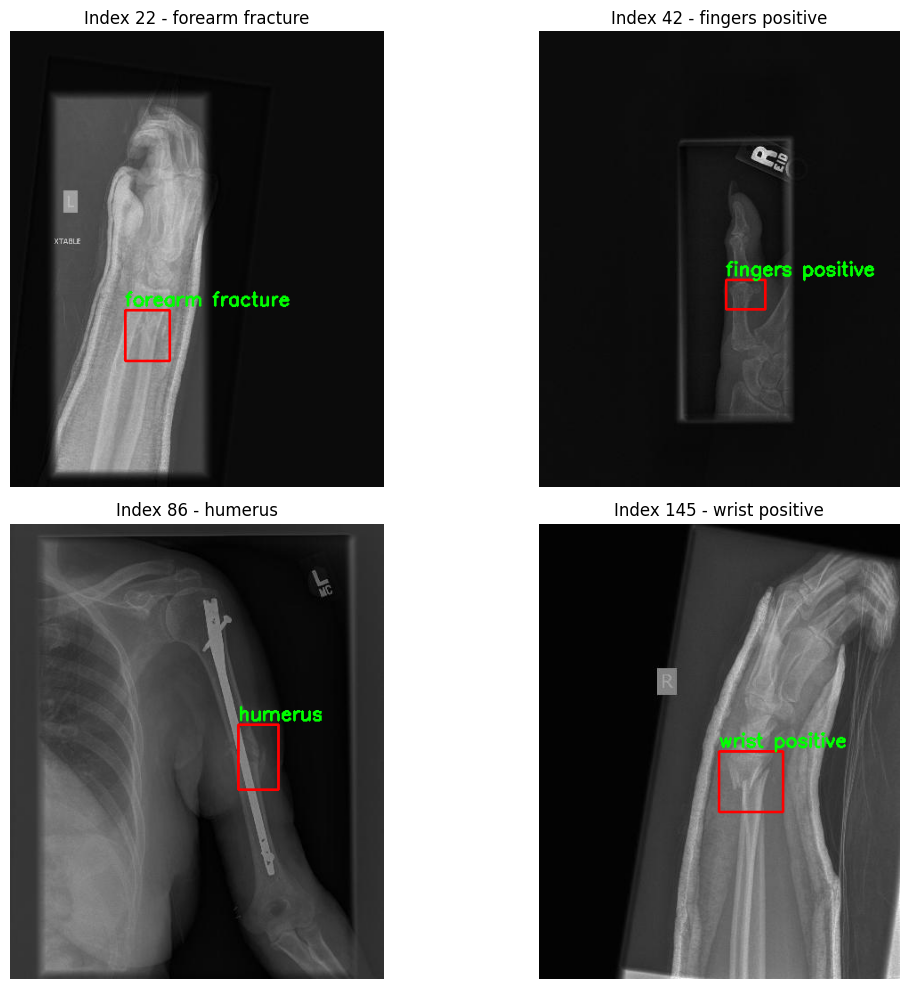

In [9]:
def visualize_detections(indices, test_imgs, results):
    rows = (len(indices) + 1) // 2
    plt.figure(figsize=(12, 10))

    for i, idx in enumerate(indices):
        img = cv2.imread(test_imgs[idx])
        try:
            boxes = list(map(int, results[idx].boxes.xywh[0]))
            x, y, w, h = boxes
            class_index = int(results[idx].boxes.cls[0])
            class_name = results[idx].names[class_index]
            cv2.rectangle(img, (x - w//2, y - h//2), ((x - w//2) + w, (y - h//2) + h), (0, 0, 255), 2)
            cv2.putText(img, class_name, (x - w//2, y - h//2 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        except IndexError:
            class_name = "No Fracture Detected"

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, 2, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Index {idx} - {class_name}")

    plt.tight_layout()
    plt.show()
    
visualize_detections([22, 42, 86, 145], test, results)